<a href="https://colab.research.google.com/github/shahad-jeza/Industrial_hackathon/blob/main/routing_algotrhim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install ortools

In [18]:
import pandas as pd
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic

# Load Data from CSV files
sales_orders = pd.read_csv('/content/orders.csv')
customers = pd.read_csv('/content/customers.csv')
trucks = pd.read_csv('/content/trucks.csv')
products = pd.read_csv('/content/products.csv', encoding='latin-1')

# Step 1: Aggregate Sales Order data to compute total pallets per customer
def compute_pallets(sales_orders, products):
    sales_orders = pd.merge(sales_orders, products[['Item #', 'Cases per Pallet']], on='Item #')
    sales_orders['Pallets'] = sales_orders['SalesQty'] / sales_orders['Cases per Pallet']
    customer_pallets = sales_orders.groupby('Customer #').agg({'Pallets': 'sum'}).reset_index()
    return customer_pallets

customer_pallets = compute_pallets(sales_orders, products)

# Step 2: Merge customer location data with aggregated pallets
customer_data = pd.merge(customer_pallets, customers, left_on='Customer #', right_on='customerNo')

# Step 3: Truck assignment based on capacity
def assign_trucks(customer_data, trucks):
    assignments = []
    truck_capacities = trucks.set_index('Truck Name')['Capacity (Pallets)'].to_dict()  # Dictionary of truck capacities

    for index, customer in customer_data.iterrows():
        customer_pallets = customer['Pallets']
        for truck_name in truck_capacities.keys():
            if customer_pallets <= truck_capacities[truck_name]:
                assignments.append((customer['Customer #'], truck_name))
                truck_capacities[truck_name] -= customer_pallets  # Deduct assigned pallets from truck capacity
                break  # Move to the next customer once assigned
    return pd.DataFrame(assignments, columns=['Customer #', 'Assigned Truck'])

truck_assignments = assign_trucks(customer_data, trucks)

# Step 4: Distance matrix calculation for route optimization
def create_distance_matrix(customer_data):
    distance_matrix = np.zeros((len(customer_data), len(customer_data)))
    for i, customer_a in customer_data.iterrows():
        for j, customer_b in customer_data.iterrows():
            if i != j:
                distance_matrix[i][j] = geodesic(
                    (customer_a['Latitude'], customer_a['Longitude']),
                    (customer_b['Latitude'], customer_b['Longitude'])
                ).km
    return distance_matrix

distance_matrix = create_distance_matrix(customer_data)

# Step 5: Use Google OR-Tools to optimize routes
def optimize_routes(distance_matrix):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route
    else:
        return None

optimized_route = optimize_routes(distance_matrix)

# Step 6: Display optimized truck assignments and routes
print("Truck Assignments:")
print(truck_assignments)

print("\nOptimized Route (Customer Order):")
for idx in optimized_route:
    print(customer_data.iloc[idx]['Customer #'])

<ipython-input-18-fafd20eb2df1>:8: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_orders = pd.read_csv('/content/orders.csv')


Truck Assignments:
    Customer # Assigned Truck
0     100022.0      TruckA8 1
1     100096.0      TruckA8 1
2     100099.0      TruckA8 1
3     100258.0      TruckA8 1
4     100297.0      TruckB6 1
5     100364.0      TruckB6 1
6     100388.0      TruckA8 1
7     100452.0      TruckB6 2
8     100480.0      TruckB6 3
9     100491.0      TruckA8 1
10    100495.0      TruckB6 2
11    100574.0      TruckB6 2
12    100575.0      TruckB6 2
13    100956.0      TruckB6 2
14    100997.0      TruckB6 4
15    101605.0      TruckB6 4
16    101617.0      TruckB6 4
17    101720.0      TruckB6 4
18    101725.0      TruckB6 5
19    101726.0      TruckB6 5
20    101732.0      TruckB6 6
21    101734.0      TruckB6 5
22    101765.0      TruckA8 1
23    101773.0      TruckB6 6
24    101894.0      TruckB6 6
25    101906.0      TruckB6 7
26    101936.0      TruckB6 1
27    102100.0      TruckB6 7
28    102309.0      TruckA8 1
29    102854.0      TruckB6 1
30    102985.0      TruckB6 3
31    103345.0      T

In [19]:
import pandas as pd
import folium
from folium.features import DivIcon

# Optimized route output you received
optimized_route = [
    100022.0, 104174.0, 104166.0, 104085.0, 104054.0, 103947.0, 103932.0,
    103836.0, 103678.0, 103589.0, 103519.0, 103514.0, 103345.0, 102985.0,
    102854.0, 102309.0, 102264.0, 102231.0, 102215.0, 102100.0, 101936.0,
    101906.0, 101894.0, 101773.0, 101765.0, 101747.0, 101745.0, 101743.0,
    101737.0, 101736.0, 101734.0, 101732.0, 101730.0, 101728.0, 101726.0,
    101725.0, 101720.0, 101718.0, 101709.0, 101617.0, 101605.0, 100997.0,
    100956.0, 100575.0, 100574.0, 100495.0, 100491.0, 100480.0, 100452.0,
    100388.0, 100364.0, 100297.0, 100258.0, 100192.0, 100099.0, 100096.0,
    100022.0
]

# Customer data
customer_data = {
    'customerNo': [102215, 104085, 103678, 104166, 101617, 101773, 102264, 101747, 103589, 100575],
    'Latitude': [21.501795, 21.74588167, 21.58945167, 21.45495833, 21.7710044, 21.5414813, 21.42749167, 21.43649657, 21.85089667, 21.30870532],
    'Longitude': [39.24419833, 39.19407, 39.21912167, 39.20741167, 39.2204109, 39.2886656, 39.19056333, 39.19649943, 39.20090833, 39.26200066]
}

# Convert customer data into a DataFrame
df_customers = pd.DataFrame(customer_data)

# Filter customer data to only include those in the optimized route
filtered_customers = df_customers[df_customers['customerNo'].isin(optimized_route)]

# Create a map centered around the first customer in the route
first_customer_lat = filtered_customers.iloc[0]['Latitude']
first_customer_lon = filtered_customers.iloc[0]['Longitude']
m = folium.Map(location=[first_customer_lat, first_customer_lon], zoom_start=12)

# Add markers for each customer in the optimized route
for idx, row in filtered_customers.iterrows():
    # Number each customer marker
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Customer: {row['customerNo']}",
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt">{idx + 1}</div>""")
    ).add_to(m)

# Draw the route with directional arrows and change start/end marker color
route_coords = list(zip(filtered_customers['Latitude'], filtered_customers['Longitude']))

# Draw start and end points with distinct colors
folium.Marker(
    location=[route_coords[0][0], route_coords[0][1]],
    popup="Start Point",
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    location=[route_coords[-1][0], route_coords[-1][1]],
    popup="End Point",
    icon=folium.Icon(color='red')
).add_to(m)

# Add arrows between points to show the direction of the route
for i in range(len(route_coords) - 1):
    folium.PolyLine(
        locations=[route_coords[i], route_coords[i + 1]],
        color='blue',
        weight=2.5,
        opacity=0.8
    ).add_to(m)

    # Add an arrow to show direction
    folium.RegularPolygonMarker(
        location=((route_coords[i][0] + route_coords[i + 1][0]) / 2,
                  (route_coords[i][1] + route_coords[i + 1][1]) / 2),
        fill_color='blue',
        number_of_sides=3,
        radius=8,
        rotation=0,
    ).add_to(m)

# Display the map
m

In [20]:
import folium

# Create a map centered around the average location of customers
map_center = [customers['Latitude'].mean(), customers['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each customer with their assigned truck
for index, row in truck_assignments.iterrows():
    customer_info = customers[customers['customerNo'] == row['Customer #']].iloc[0]
    folium.Marker(
        location=[customer_info['Latitude'], customer_info['Longitude']],
        popup=f"Customer: {row['Customer #']}<br>Assigned Truck: {row['Assigned Truck']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Display the map
m.save('truck_assignments_map.html')

In [21]:
# Display truck assignments as a styled table
styled_table = truck_assignments.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"') \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])

# To display in a Jupyter Notebook
styled_table

,Customer #,Assigned Truck
0,100022.000000,TruckA8 1
1,100096.000000,TruckA8 1
2,100099.000000,TruckA8 1
3,100258.000000,TruckA8 1
4,100297.000000,TruckB6 1
5,100364.000000,TruckB6 1
6,100388.000000,TruckA8 1
7,100452.000000,TruckB6 2
8,100480.000000,TruckB6 3
9,100491.000000,TruckA8 1


<ipython-input-22-3c97d628c523>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Assigned Truck', y='Pallets', data=pallets_count, palette='viridis')


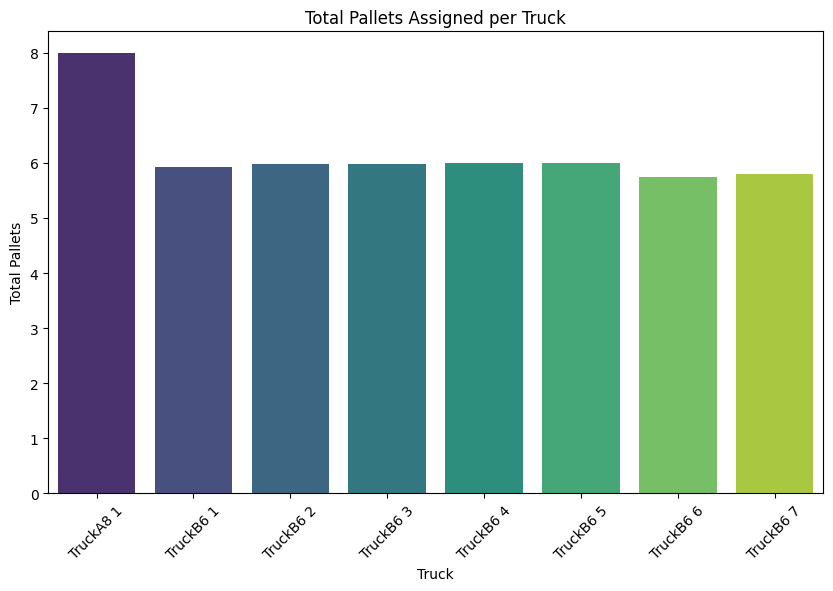

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate pallets per truck
pallets_per_truck = truck_assignments.merge(customer_pallets, on='Customer #')
pallets_count = pallets_per_truck.groupby('Assigned Truck')['Pallets'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Assigned Truck', y='Pallets', data=pallets_count, palette='viridis')
plt.title('Total Pallets Assigned per Truck')
plt.xlabel('Truck')
plt.ylabel('Total Pallets')
plt.xticks(rotation=45)
plt.show()